<a href="https://colab.research.google.com/github/Mastroiani/TCC/blob/Sandbox/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install plotly
!pip install graphviz
!pip install scikit-plot

In [2]:
import pandas as pd
import numpy as np

from time import time

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image  
import pydotplus
import pickle

import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.externals.six import StringIO
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



In [3]:
def pr_curve(ml):
  y_probas = ml.predict_proba(X_test)
  skplt.metrics.plot_precision_recall_curve(y_test, y_probas)
  plt.show()

In [4]:
def estat(ml):
  print('*********** Estatísticas da Base de Treinamento ************************\n')
  print(metrics.classification_report(y_train, ml.predict(X_train), target_names=['0','1']))

  print('*********** Estatísticas da Base de Teste ******************************\n')
  print(metrics.classification_report(y_test, ml.predict(X_test), target_names=['0','1']))

  pr_curve(ml)

In [5]:
def cv_imp(ml):
  ml_a_scores_CV = cross_val_score(ml, X_train, y_train, cv = 10)
  print(f'Média das Acurácias calculadas pelo CV....: {100*round(ml_a_scores_CV.mean(),4)}')
  print(f'std médio das Acurácias calculadas pelo CV: {100*round(ml_a_scores_CV.std(),4)}')
  print(ml_a_scores_CV)

  df_importancia_variaveis = pd.DataFrame(zip(X.columns, ml.feature_importances_), columns= ['coluna', 'importancia'])
  df_importancia_variaveis = df_importancia_variaveis.sort_values(by= ['importancia'], ascending=False)
  print('\n****************** Importância das Colunas **********************\n')
  print(df_importancia_variaveis)

In [6]:
def pred_comp(ml):
  y_pred = ml.predict(X_test)
  y_real = np.array(y_test['incompatibil'].to_list())
  print(f'Variáveis Preditas:\n {y_pred}')
  print(f'Variáveis Reais:\n {y_real}')

In [8]:
path = '/content/drive/MyDrive/TCCARQ7'
name = 'dataset_preprocessado_TCC'

df = pd.read_csv(f'{path}/{name}')
df.shape

(1180, 38)

In [9]:
X = df[['pais_de_origem_enc', 'pais_de_aquisicao_enc','unidade_desembaraco_enc', 'incoterm_enc',
       'qtde_estatistica',
       'vmle_dolar',
       'vl_frete_dolar',
       'vl_seguro_dolar',
       'valor_un_prod_dolar',
       'qtd_comercial',
       'peso_liquido_rateado',
       'valor_frete_rateado',
       'seguro_rateado',
       'total_unitario_fob',
       'fob_kg'
       ]]

y = df[['incompatibil']]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 64)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(826, 15) (354, 15) (826, 1) (354, 1)


In [11]:
def mostra_confusion_matrix(cf,
    group_names = None, categories = 'auto', count = True, percent = True, cbar = True, xyticks = False, xyplotlabels = True, sum_stats = True, figsize = (6, 6), cmap = 'Reds'):
    
    # Gera o texto dentro de cada quadrado
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # Gera estastísticas de teste
    if sum_stats:
        accuracy = np.trace(cf) / float(np.sum(cf))

        # caso se trate de matriz confusão binária informa estatísticas adicionais (Precisão, Revocação e F1 Score)
        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAcurácia={:0.4f}\nPrecisão={:0.4f}\nRevocação={:0.4f}\nF1 Score={:0.4f}".format(accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAcurácia={:0.4f}".format(accuracy)
    else:
        stats_text = ""

    # Plota o mapa de calor
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

In [12]:
# função de treinamento do modelo
def train_model(ml):
    ml.fit(X_train, y_train)
    
    # argumentos da função 'mostra_confusion_matrix'
    cf_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    cf_categories = [0,1]
    pred = ml.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    
    #função de plotagem da matriz confusão e estatísticas de teste relacionadas ao modelo
    mostra_confusion_matrix(cm, group_names = cf_labels, categories= cf_categories)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=64, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



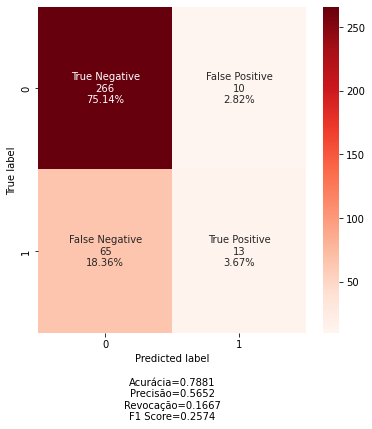

In [13]:
# instanciando modelo 'ml_SVC' de hiperparâmetros default
ml_SVC = SVC(probability=True, random_state=64)
print(ml_SVC)

# executando o treinamento do modelo
train_model(ml_SVC)

In [16]:
y_train

,incompatibil
1130,0
351,0
655,1
948,0
919,1
...,...
814,1
498,0
368,0
220,0


In [18]:
oversample = SMOTE()
X_train2, y_train2 = oversample.fit_resample(X_train, y_train)

NameError: ignored

In [17]:
counter = Counter(y_train)
print(counter)

Counter({'incompatibil': 1})
